In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

1. A product can have multiple ListPrices at the same point in time. However, the field(s) that are responsible for these variations are unknown. Investigate ProdId = 528 to determine why ListPrices vary between 2012-01-01 to 2013-01-01.

In [166]:
data = pd.read_table("/Users/Yeti/Desktop/insight2profit/merged_case.txt")
df = pd.DataFrame(data)

In [167]:
pd.set_option('display.max_columns', None)

In [168]:
# I like to start by getting to see what I'm dealing with
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528960 entries, 0 to 528959
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   QuoteTypeKey        528960 non-null  int64  
 1   CustId              528960 non-null  int64  
 2   ProdId              528960 non-null  int64  
 3   InvoiceId           528960 non-null  int64  
 4   InvoiceDate         528960 non-null  object 
 5   LineNumber          528960 non-null  int64  
 6   Volume              528960 non-null  int64  
 7   Revenue             528960 non-null  float64
 8   Cost                528960 non-null  float64
 9   ExtendedCost        528960 non-null  float64
 10  ListPrice           528960 non-null  float64
 11  flag1               528960 non-null  object 
 12  ProductNumber       528960 non-null  object 
 13  ProductDescription  528960 non-null  object 
 14  ProductFamily       528960 non-null  object 
 15  ProductStatus       528960 non-nul

In [169]:
df.describe().applymap('{:,.2f}'.format)

,QuoteTypeKey,CustId,ProdId,InvoiceId,LineNumber,Volume,Revenue,Cost,ExtendedCost,ListPrice,CustomerNumber,UnitPrice,Multiplier,Discount
count,"528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00","528,960.00"
mean,"19,790.50","2,731.26","7,664.05","1,741,837.30",7.94,4.20,202.76,35.17,103.20,96.75,"902,275.55",77.62,inf,-inf
std,"11,430.60","1,415.86","5,877.68","909,267.24",26.34,14.66,535.30,39.40,778.48,141.80,"1,426.26",91.06,nan,nan
min,1.00,2.00,1.00,1.00,1.00,1.00,0.02,0.00,0.00,0.00,"900,000.00",0.02,0.00,-inf
25%,"6,380.00","1,305.00","2,326.00","1,052,885.00",1.00,1.00,54.58,12.08,23.08,32.50,"900,970.00",28.06,0.89,0.00
50%,"29,739.00","3,115.00","6,638.00","1,753,544.50",2.00,2.00,108.96,23.42,46.86,62.30,"902,332.00",56.70,1.00,0.00
75%,"29,739.00","3,872.00","12,312.00","2,376,840.00",7.00,4.00,210.00,43.99,93.69,109.00,"903,655.00",97.38,1.00,0.11
max,"29,739.00","4,901.00","20,443.00","3,862,038.00",927.00,"1,800.00","68,085.00","1,772.40","268,494.39","5,900.00","904,781.00","8,263.10",inf,1.00


In [170]:
df.nunique()

QuoteTypeKey               5
CustId                  2677
ProdId                  8585
InvoiceId             528960
InvoiceDate              308
LineNumber               887
Volume                   318
Revenue                24897
Cost                   11256
ExtendedCost           48480
ListPrice               1905
flag1                     11
ProductNumber           8585
ProductDescription      2337
ProductFamily            688
ProductStatus              3
Line                       7
Style                     10
LED                        2
Commodity                  2
EnergyEfficient            2
ProductLabel            8585
Category                 138
ProductManager            14
CustomerNumber          2677
CustomerName            2677
CustomerChannel            7
SalesPersonName          138
CustomerLabel           2677
region                     8
QuoteTypeName              5
UnitPrice              11076
Multiplier             15435
Discount               15898
dtype: int64

In [171]:
# It's useful to look at columns with few unique values for patterns
# Clean the data of any Null values

df.isna().sum()

QuoteTypeKey               0
CustId                     0
ProdId                     0
InvoiceId                  0
InvoiceDate                0
LineNumber                 0
Volume                     0
Revenue                    0
Cost                       0
ExtendedCost               0
ListPrice                  0
flag1                      0
ProductNumber              0
ProductDescription         0
ProductFamily              0
ProductStatus              0
Line                  345132
Style                      0
LED                        0
Commodity                  0
EnergyEfficient            0
ProductLabel               0
Category                   0
ProductManager             0
CustomerNumber             0
CustomerName               0
CustomerChannel            0
SalesPersonName            0
CustomerLabel              0
region                     0
QuoteTypeName              0
UnitPrice                  0
Multiplier                 0
Discount                   0
dtype: int64

In [172]:
na_sum = df.isna().sum()
has_na_values = na_sum > 0

In [173]:
col_with_na = na_sum[has_na_values]
print(col_with_na)

Line    345132
dtype: int64


In [174]:
df['Line'].unique()

array([nan, 'Acme Standard', 'Builder', 'Decorative Fans',
       'Floor Lamps and Mirrors', 'Landscape', 'Builder Fans', 'Cabinets'],
      dtype=object)

In [175]:
# Nearly half of the Line is filled with Nan but the other half has usefull information
# We'll leave it alone, and the only other issue is that theres a -inf as a min for discount

df['Discount'].sort_values()

102176        -inf
71932         -inf
174116        -inf
328294        -inf
328352        -inf
            ...   
87575     0.999472
151176    0.999484
170215    0.999612
151409    0.999749
151231    0.999758
Name: Discount, Length: 528960, dtype: float64

In [176]:
prod_inf = df.loc[df['Discount'] == float('-inf')]
prod_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 27146 to 328352
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   QuoteTypeKey        109 non-null    int64  
 1   CustId              109 non-null    int64  
 2   ProdId              109 non-null    int64  
 3   InvoiceId           109 non-null    int64  
 4   InvoiceDate         109 non-null    object 
 5   LineNumber          109 non-null    int64  
 6   Volume              109 non-null    int64  
 7   Revenue             109 non-null    float64
 8   Cost                109 non-null    float64
 9   ExtendedCost        109 non-null    float64
 10  ListPrice           109 non-null    float64
 11  flag1               109 non-null    object 
 12  ProductNumber       109 non-null    object 
 13  ProductDescription  109 non-null    object 
 14  ProductFamily       109 non-null    object 
 15  ProductStatus       109 non-null    object 
 16  L

In [177]:
prod_inf.nunique()

QuoteTypeKey            3
CustId                 57
ProdId                 58
InvoiceId             109
InvoiceDate            72
LineNumber             17
Volume                 20
Revenue                86
Cost                   57
ExtendedCost           71
ListPrice               1
flag1                   8
ProductNumber          58
ProductDescription     45
ProductFamily          18
ProductStatus           3
Line                    5
Style                   9
LED                     2
Commodity               2
EnergyEfficient         2
ProductLabel           58
Category               26
ProductManager         11
CustomerNumber         57
CustomerName           57
CustomerChannel         7
SalesPersonName        42
CustomerLabel          57
region                  8
QuoteTypeName           3
UnitPrice              76
Multiplier              1
Discount                1
dtype: int64

In [179]:
prod_inf.loc[prod_inf['ProdId']==528]

,QuoteTypeKey,CustId,ProdId,InvoiceId,InvoiceDate,LineNumber,Volume,Revenue,Cost,ExtendedCost,ListPrice,flag1,ProductNumber,ProductDescription,ProductFamily,ProductStatus,Line,Style,LED,Commodity,EnergyEfficient,ProductLabel,Category,ProductManager,CustomerNumber,CustomerName,CustomerChannel,SalesPersonName,CustomerLabel,region,QuoteTypeName,UnitPrice,Multiplier,Discount


In [180]:
# 109 entries are -inf, which are very few, and they're all for different and it doesn't relate to ProdId 528
# So we can leave it as something to be investigated more, later on

df['ProdId'].nunique()

8585

In [181]:
df.groupby('ProdId')['ListPrice'].nunique()

ProdId
1        2
3        4
4        2
5        1
14       1
        ..
20433    3
20435    3
20436    3
20442    1
20443    1
Name: ListPrice, Length: 8585, dtype: int64

In [182]:
diff_list = df.groupby('ProdId')['ListPrice'].nunique()
diff_list = diff_list[diff_list > 1]
diff_list

ProdId
1        2
3        4
4        2
17       3
18       4
        ..
20423    2
20426    2
20433    3
20435    3
20436    3
Name: ListPrice, Length: 4787, dtype: int64

In [184]:
# It looks like out of the 8585 different ProdId's, 4787 have atleast 2 different ListPrices
prod = prod_528.loc[(prod_528['InvoiceDate'] > '2012-01-01') & (prod_528['InvoiceDate'] < '2013-01-01')]
prod.info()
prod_528 = df.loc[df['ProdId'] == 528]
prod_528.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 27376 to 528412
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   QuoteTypeKey        1466 non-null   int64  
 1   CustId              1466 non-null   int64  
 2   ProdId              1466 non-null   int64  
 3   InvoiceId           1466 non-null   int64  
 4   InvoiceDate         1466 non-null   object 
 5   LineNumber          1466 non-null   int64  
 6   Volume              1466 non-null   int64  
 7   Revenue             1466 non-null   float64
 8   Cost                1466 non-null   float64
 9   ExtendedCost        1466 non-null   float64
 10  ListPrice           1466 non-null   float64
 11  flag1               1466 non-null   object 
 12  ProductNumber       1466 non-null   object 
 13  ProductDescription  1466 non-null   object 
 14  ProductFamily       1466 non-null   object 
 15  ProductStatus       1466 non-null   object 
 16  

In [185]:
# it seems like all of the orders related to prod 528 were in that one year
# lets double check

print("Earliest date: {0} \n Latest Date: {1}".format(prod_528['InvoiceDate'].min(), prod_528['InvoiceDate'].max()))

Earliest date: 2012-01-03 
 Latest Date: 2012-12-31


In [186]:
# alright, so far all I know is that all of 528 was ordered in that one year

prod.nunique()

QuoteTypeKey             4
CustId                 465
ProdId                   1
InvoiceId             1466
InvoiceDate            275
LineNumber              24
Volume                  31
Revenue                150
Cost                     7
ExtendedCost            73
ListPrice                6
flag1                    9
ProductNumber            1
ProductDescription       1
ProductFamily            1
ProductStatus            1
Line                     0
Style                    1
LED                      1
Commodity                1
EnergyEfficient          1
ProductLabel             1
Category                 1
ProductManager           1
CustomerNumber         465
CustomerName           465
CustomerChannel          7
SalesPersonName        105
CustomerLabel          465
region                   8
QuoteTypeName            4
UnitPrice               44
Multiplier              40
Discount                47
dtype: int64

In [187]:
# lets drop all columns that have 1 or less unique values, because that won't help us with investigating

unique_counts = prod.nunique()
to_drop = unique_counts[unique_counts <= 1].index
prod_unique = prod.drop(to_drop, axis=1)
prod_unique.nunique()

QuoteTypeKey          4
CustId              465
InvoiceId          1466
InvoiceDate         275
LineNumber           24
Volume               31
Revenue             150
Cost                  7
ExtendedCost         73
ListPrice             6
flag1                 9
CustomerNumber      465
CustomerName        465
CustomerChannel       7
SalesPersonName     105
CustomerLabel       465
region                8
QuoteTypeName         4
UnitPrice            44
Multiplier           40
Discount             47
dtype: int64

In [188]:
prod_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1466 entries, 27376 to 528412
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QuoteTypeKey     1466 non-null   int64  
 1   CustId           1466 non-null   int64  
 2   InvoiceId        1466 non-null   int64  
 3   InvoiceDate      1466 non-null   object 
 4   LineNumber       1466 non-null   int64  
 5   Volume           1466 non-null   int64  
 6   Revenue          1466 non-null   float64
 7   Cost             1466 non-null   float64
 8   ExtendedCost     1466 non-null   float64
 9   ListPrice        1466 non-null   float64
 10  flag1            1466 non-null   object 
 11  CustomerNumber   1466 non-null   int64  
 12  CustomerName     1466 non-null   object 
 13  CustomerChannel  1466 non-null   object 
 14  SalesPersonName  1466 non-null   object 
 15  CustomerLabel    1466 non-null   object 
 16  region           1466 non-null   object 
 17  QuoteTyp

<AxesSubplot:xlabel='region', ylabel='ListPrice'>

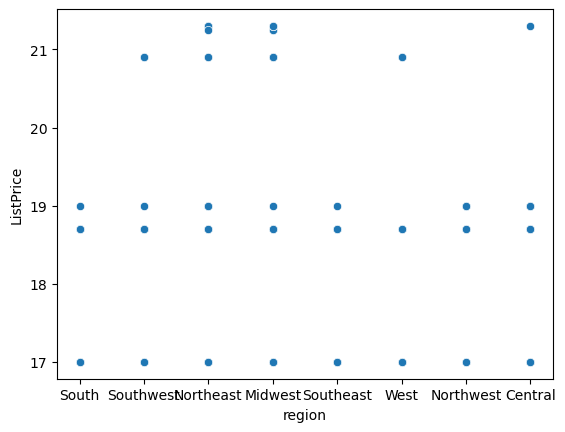

In [189]:
# Just from glancing at the above, its worth starting by looking at Region and Cost
# both make sense for reasons why ListPrices would vary

sns.scatterplot(data=prod_unique, x='region', y='ListPrice')

In [ ]:
# we have 8 different regions, perhaps each region has its own list price

prod_unique.groupby('ListPrice')['region'].unique()

ListPrice
17.00    [Northeast, Midwest, South, Southeast, West, N...
18.70    [South, Midwest, Northwest, Southwest, Northea...
19.00    [South, Southeast, Northeast, Northwest, Midwe...
20.90                [Southwest, Midwest, Northeast, West]
21.25                                 [Northeast, Midwest]
21.30                        [Central, Northeast, Midwest]
Name: region, dtype: object

In [ ]:
# we can see that one region doesn't pay only one price
# lets see if we can check if there are unique values for each list price for other features

group = prod_unique.groupby('ListPrice')['region'].unique()
count = 0
for i, (price1, region1) in enumerate(group.items()):
    for price2, region2 in list(group.items())[i+1:]:
        common = set(region1).intersection(region2)
        if common:
            print(f"Common Regions between ListPrice {price1} and {price2}: {common}")
            count += 1
    if count == 0:
        print(f"No common Region between different list prices. \nRegions may be a reason for different list prices.")

Common Regions between ListPrice 17.0 and 18.7: {'Northeast', 'Central', 'Northwest', 'Southeast', 'West', 'South', 'Midwest', 'Southwest'}
Common Regions between ListPrice 17.0 and 19.0: {'Northeast', 'Central', 'Northwest', 'Southeast', 'South', 'Midwest', 'Southwest'}
Common Regions between ListPrice 17.0 and 20.9: {'Southwest', 'West', 'Midwest', 'Northeast'}
Common Regions between ListPrice 17.0 and 21.25: {'Midwest', 'Northeast'}
Common Regions between ListPrice 17.0 and 21.3: {'Central', 'Midwest', 'Northeast'}
Common Regions between ListPrice 18.7 and 19.0: {'Northeast', 'Central', 'Northwest', 'Southeast', 'South', 'Midwest', 'Southwest'}
Common Regions between ListPrice 18.7 and 20.9: {'Southwest', 'West', 'Midwest', 'Northeast'}
Common Regions between ListPrice 18.7 and 21.25: {'Midwest', 'Northeast'}
Common Regions between ListPrice 18.7 and 21.3: {'Central', 'Midwest', 'Northeast'}
Common Regions between ListPrice 19.0 and 20.9: {'Southwest', 'Midwest', 'Northeast'}
Common

In [ ]:
# if there were no shared regions, then that would have been an explanation for different list prices
# using the same technique as above, lets iterate through all the columns, and see if any featues have unique values for each list price

no_common = []
for columnName in prod_unique:
    if columnName == 'ListPrice':
        pass
    else:
        feature = columnName
        grouped = prod_unique.groupby('ListPrice')[feature].unique()
        count = 0
        for i, (price1, feature1) in enumerate(grouped.items()):
            for price2, feature2 in list(grouped.items())[i+1:]:
                common_features = set(feature1).intersection(set(feature2))
                if common_features:
                    # print(f"Feature {feature} with with ListPrice {price1} and {price2}: {common_features}")
                    count += 1
        if count == 0:
            # print(f"No common {feature} between different list prices. \n{feature} may be a reason for different list prices.")
            no_common.append(feature)
print(no_common)

['InvoiceId', 'flag1']


In [ ]:
# InvoiceID and flag1 are features that have different values for each list price

prod_unique.groupby('ListPrice')['flag1'].unique()

ListPrice
17.00    [ZONE_1_NET, ZONE_4_NET, ZONE_ALCHE]
18.70                  [ZONE_1_NS, ZONE_4_NS]
19.00                            [ZONE_2_CAN]
20.90                             [ZONE_2_NS]
21.25                            [ZONE_7_NSD]
21.30                            [ZONE_3_NSK]
Name: flag1, dtype: object

In [ ]:
# lets use the same technique on the whole dataset

# get list of unique counts for list price for each prodId
unique_prod_count = df.groupby('ProdId')['ListPrice'].nunique()
# get a list of prodIds with 1 or less unique listprice
to_drop = unique_prod_count[unique_prod_count <= 1].index
# get a dataframe where we drop all the prodIds that are in the previous list
prod2 = df.loc[~df['ProdId'].isin(to_drop)]
# return only a list of the product id
products = prod2.groupby('ProdId')['ListPrice'].nunique().index

prod_list = []
for prod_id in products:
    no_common = []
    prod_unique = df.loc[df['ProdId']==prod_id]
    for columnName in prod_unique:
        if columnName == 'ListPrice':
            pass
        else:
            feature = columnName
            grouped = prod_unique.groupby('ListPrice')[feature].unique()
            count = 0
            for i, (price1, feature1) in enumerate(grouped.items()):
                for price2, feature2 in list(grouped.items())[i+1:]:
                    common_features = set(feature1).intersection(set(feature2))
                    if common_features:
                        count += 1
            if count == 0:
                no_common.append(feature)

    prod_list.append(f"Product {prod_id}  List Price variations can be caused by  {no_common}")
print(*prod_list, sep = "\n")

Product 1  List Price variations can be caused by  ['CustId', 'InvoiceId', 'Revenue', 'flag1', 'CustomerNumber', 'CustomerName', 'CustomerLabel', 'UnitPrice']
Product 3  List Price variations can be caused by  ['CustId', 'InvoiceId', 'LineNumber', 'Revenue', 'CustomerNumber', 'CustomerName', 'CustomerLabel', 'UnitPrice']
Product 4  List Price variations can be caused by  ['CustId', 'InvoiceId', 'InvoiceDate', 'Revenue', 'flag1', 'CustomerNumber', 'CustomerName', 'SalesPersonName', 'CustomerLabel', 'region', 'UnitPrice']
Product 17  List Price variations can be caused by  ['InvoiceId']
Product 18  List Price variations can be caused by  ['CustId', 'InvoiceId', 'flag1', 'CustomerNumber', 'CustomerName', 'CustomerLabel', 'UnitPrice']
Product 24  List Price variations can be caused by  ['CustId', 'InvoiceId', 'Revenue', 'CustomerNumber', 'CustomerName', 'CustomerLabel', 'UnitPrice']
Product 25  List Price variations can be caused by  ['CustId', 'InvoiceId', 'InvoiceDate', 'Volume', 'Revenu

From the above list, we can tell the 4787 ProdId's have different reasons for having different List Prices. But for ProdId 528, and its 1466 orders, each zone had a different ListPrice except for 17.00 and 18.70. Those two list prices had more than 1 zone, but those zones were not shared among other list prices. If a zone was found with one list price, it wouldn't be found with any other.

With more time, I would like to look into the correlation between Cost and ListPrice as well.

2. What is one of the priary explanatory variables for discounting behavior. Perform a quantiatative analysis to identify one of the main variables that explains discounting.

UnitPrice = Revenue/Volume

Discount = 1-(UnitPrice/ListPrice)

In [191]:
df['Discount'].describe()

count    5.289600e+05
mean             -inf
std               NaN
min              -inf
25%      0.000000e+00
50%      0.000000e+00
75%      1.093333e-01
max      9.997577e-01
Name: Discount, dtype: float64

In [192]:
prod_inf = df.loc[df['Discount'] == float('-inf')]
prod_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 27146 to 328352
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   QuoteTypeKey        109 non-null    int64  
 1   CustId              109 non-null    int64  
 2   ProdId              109 non-null    int64  
 3   InvoiceId           109 non-null    int64  
 4   InvoiceDate         109 non-null    object 
 5   LineNumber          109 non-null    int64  
 6   Volume              109 non-null    int64  
 7   Revenue             109 non-null    float64
 8   Cost                109 non-null    float64
 9   ExtendedCost        109 non-null    float64
 10  ListPrice           109 non-null    float64
 11  flag1               109 non-null    object 
 12  ProductNumber       109 non-null    object 
 13  ProductDescription  109 non-null    object 
 14  ProductFamily       109 non-null    object 
 15  ProductStatus       109 non-null    object 
 16  L

In [193]:
# 109 entries is less than 1% of our values, so we're going to drop those rows, we can investigate more later

df2 = df.loc[df['Discount'] != float('-inf')]

In [194]:
df2.Discount.describe(include='all')

count    528851.000000
mean          0.085814
std           0.246498
min        -120.695140
25%           0.000000
50%           0.000000
75%           0.109333
max           0.999758
Name: Discount, dtype: float64

In [195]:
# To begin, the cost of a product, volume of product sold, what region or zone the product is being sold, 
# and the ListPrice of a product usually has a impact on the discount rate.

df2.select_dtypes(exclude=['object']).head()

,QuoteTypeKey,CustId,ProdId,InvoiceId,LineNumber,Volume,Revenue,Cost,ExtendedCost,ListPrice,CustomerNumber,UnitPrice,Multiplier,Discount
0,1,73,127,114627,9,2,48.8,11.5452,23.0904,30.0,904435,24.4,0.813333,0.186667
1,1,73,127,806633,1,1,24.4,11.5452,11.5452,30.0,904435,24.4,0.813333,0.186667
2,1,73,127,959754,5,6,146.4,11.5452,69.2712,30.0,904435,24.4,0.813333,0.186667
3,1,73,127,1030587,10,7,170.8,11.5452,80.8164,30.0,904435,24.4,0.813333,0.186667
4,1,73,127,1031099,1,7,170.8,11.5452,80.8164,30.0,904435,24.4,0.813333,0.186667


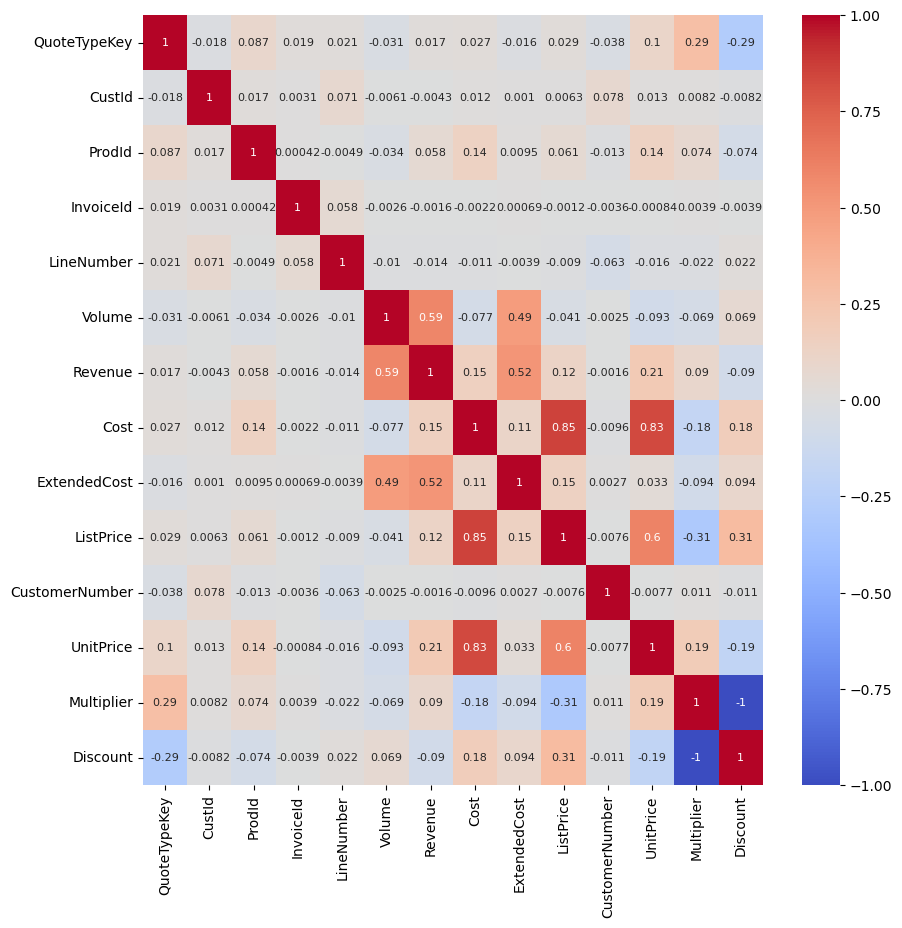

In [196]:
# We can tell a couple of things from basic arithmitic
# Discount + Multiplier = 1
# UnitPrice = ListPrice * Multiplier
# Revenue =  UnitPrice * Volume
# lets see which columns correlate with Discount

corr_matrix = df2.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'fontsize':8})
plt.show()

In [197]:
corr_with_discount = corr_matrix['Discount'].sort_values(ascending=False)
print(corr_with_discount)

Discount          1.000000
ListPrice         0.310991
Cost              0.179354
ExtendedCost      0.093668
Volume            0.069218
LineNumber        0.021999
InvoiceId        -0.003890
CustId           -0.008234
CustomerNumber   -0.011313
ProdId           -0.074255
Revenue          -0.090057
UnitPrice        -0.194147
QuoteTypeKey     -0.288828
Multiplier       -1.000000
Name: Discount, dtype: float64


In [198]:
# multipler has a direct opposite correlation, which makes sense
# strongest positive correlation: ListPrice, Cost
# strongest negative correlation: QuoteTypeKey, UnitPrice
# as we predicted earlier, ListPrice and Cost has a positive correlation with Discount

df2['Discount'] = pd.to_numeric(df2['Discount'], errors='coerce')

/var/folders/tq/z0ynpr_n7xd1sz5hcrsbpdb00000gn/T/ipykernel_49365/55357763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Discount'] = pd.to_numeric(df2['Discount'], errors='coerce')


In [199]:
df2[['Discount', 'ListPrice']].corr()

,Discount,ListPrice
Discount,1.000000,0.310991
ListPrice,0.310991,1.000000


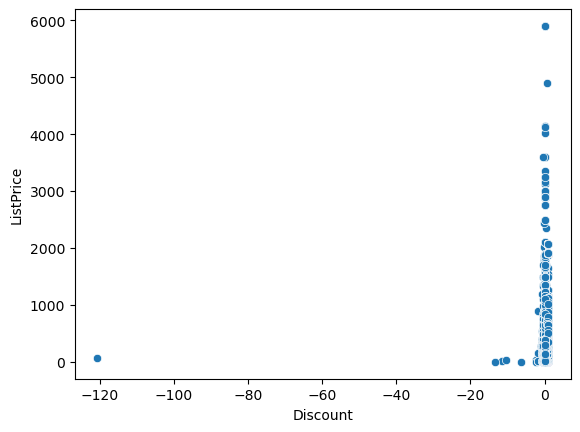

In [200]:
sns.scatterplot(data=df2, x='Discount', y='ListPrice')
plt.show()

In [201]:
# Negative values are making it harder to view

prod_neg = df.loc[df['Discount'] < 0]
prod_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9959 entries, 2123 to 528700
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   QuoteTypeKey        9959 non-null   int64  
 1   CustId              9959 non-null   int64  
 2   ProdId              9959 non-null   int64  
 3   InvoiceId           9959 non-null   int64  
 4   InvoiceDate         9959 non-null   object 
 5   LineNumber          9959 non-null   int64  
 6   Volume              9959 non-null   int64  
 7   Revenue             9959 non-null   float64
 8   Cost                9959 non-null   float64
 9   ExtendedCost        9959 non-null   float64
 10  ListPrice           9959 non-null   float64
 11  flag1               9959 non-null   object 
 12  ProductNumber       9959 non-null   object 
 13  ProductDescription  9959 non-null   object 
 14  ProductFamily       9959 non-null   object 
 15  ProductStatus       9959 non-null   object 
 16  L

In [202]:
prod_neg['Discount'].sort_values()

328294            -inf
93604             -inf
178636            -inf
90479             -inf
90478             -inf
              ...     
374570   -2.000000e-16
374658   -2.000000e-16
374784   -2.000000e-16
374211   -2.000000e-16
528700   -2.000000e-16
Name: Discount, Length: 9959, dtype: float64

In [203]:
# lets get rid of the 109 rows with -inf for Discount and the one row with -120 discount
prod_neg = prod_neg.loc[prod_neg['Discount'] != float('-inf')]
prod_neg = prod_neg.loc[prod_neg['Discount'] > -119]
prod_neg['Discount'].sort_values()

102035   -1.328571e+01
89036    -1.150000e+01
180735   -1.047875e+01
163562   -6.419355e+00
31264    -2.349222e+00
              ...     
374570   -2.000000e-16
374658   -2.000000e-16
374784   -2.000000e-16
374211   -2.000000e-16
528700   -2.000000e-16
Name: Discount, Length: 9849, dtype: float64

/var/folders/tq/z0ynpr_n7xd1sz5hcrsbpdb00000gn/T/ipykernel_49365/3907673817.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 4))


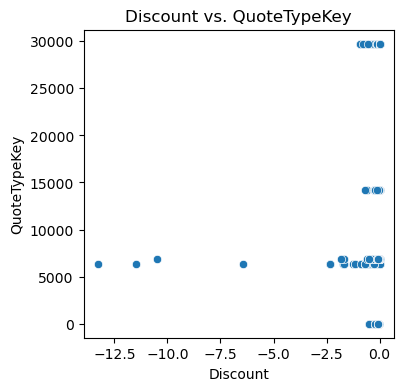

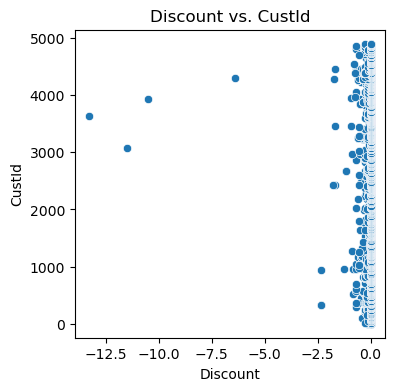

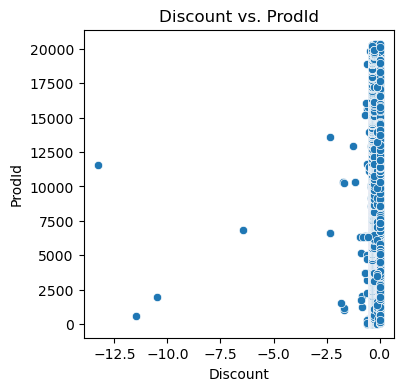

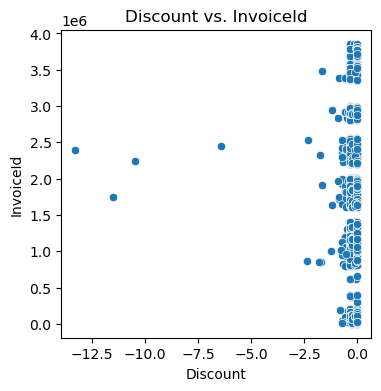

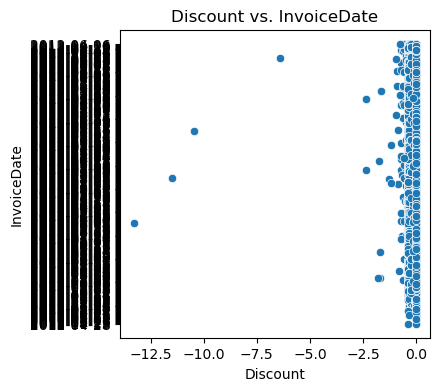

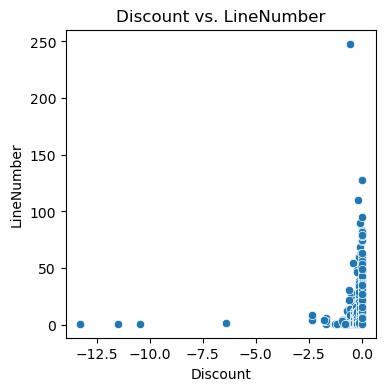

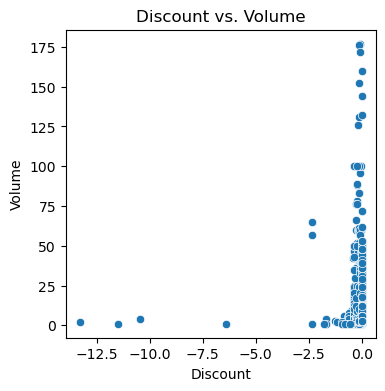

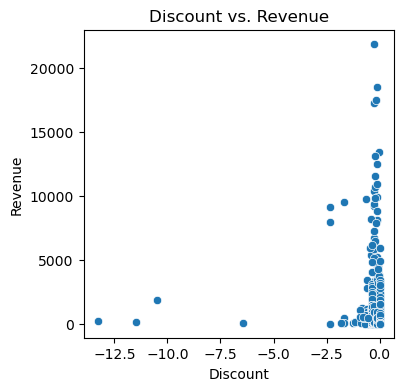

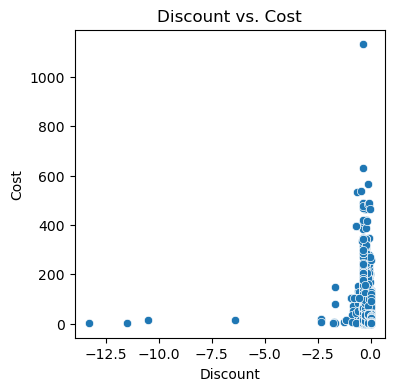

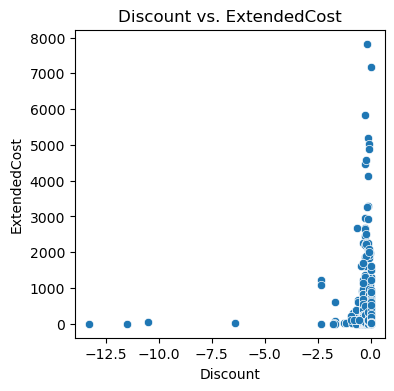

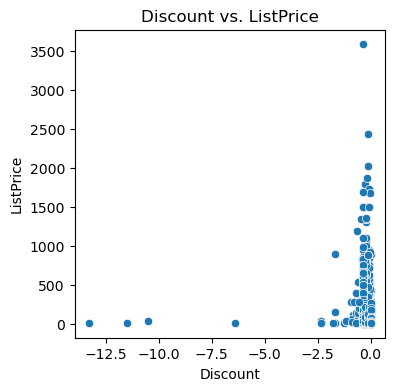

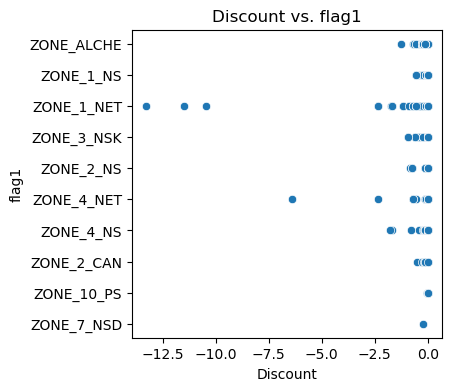

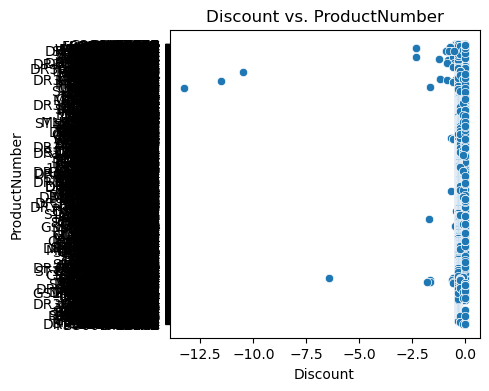

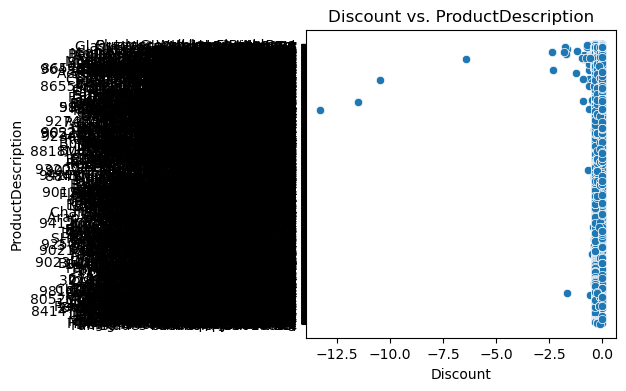

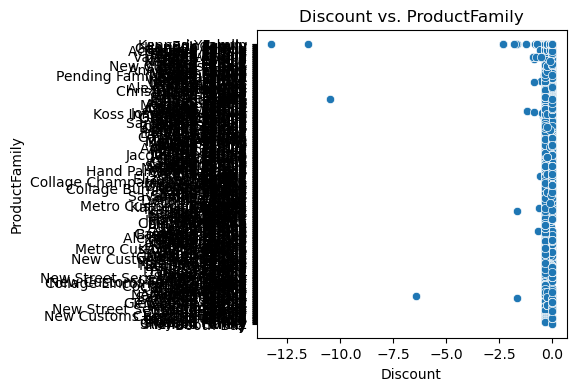

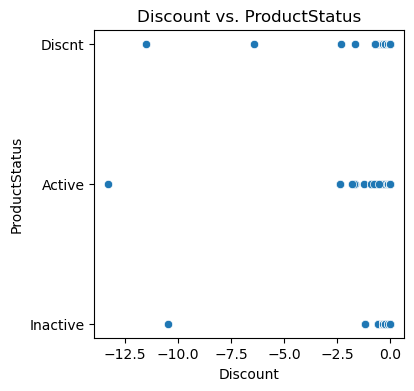

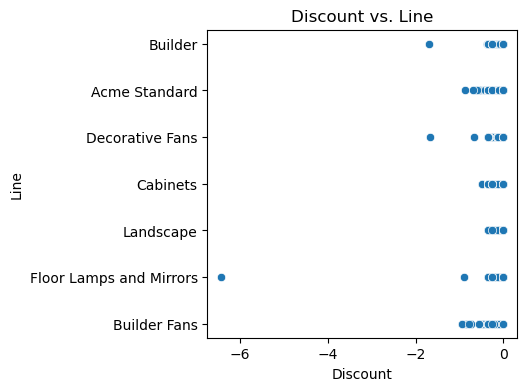

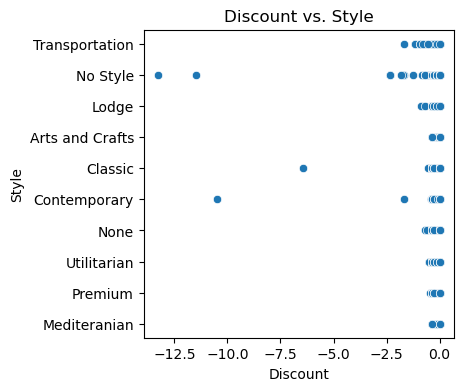

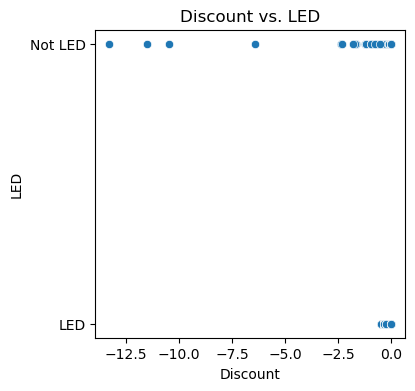

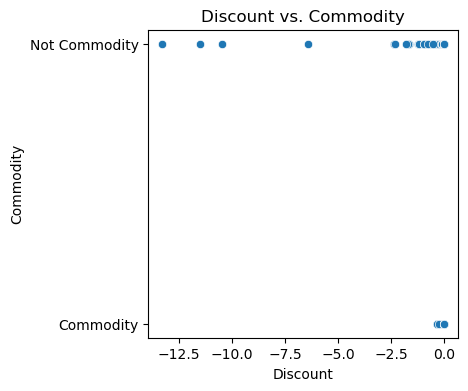

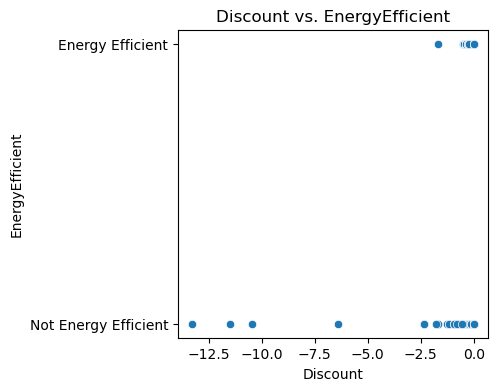

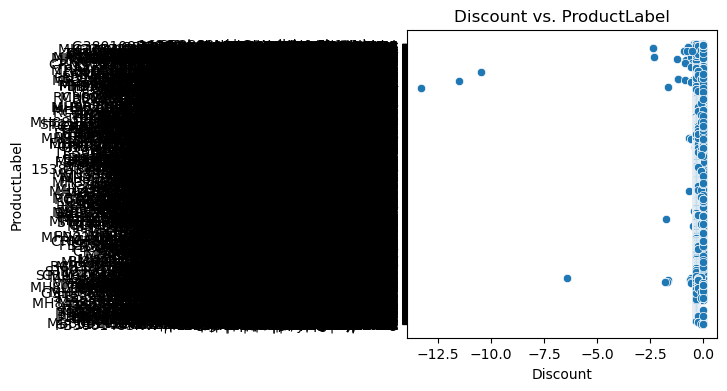

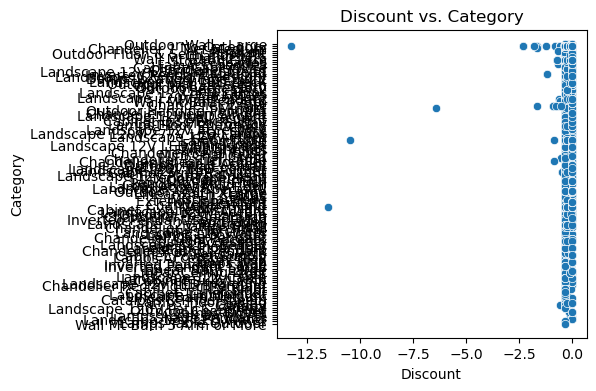

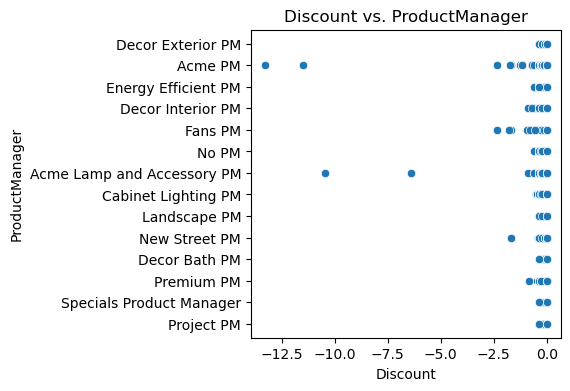

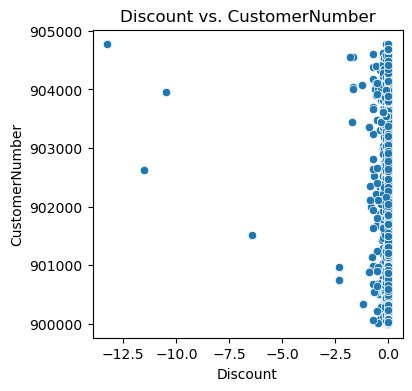

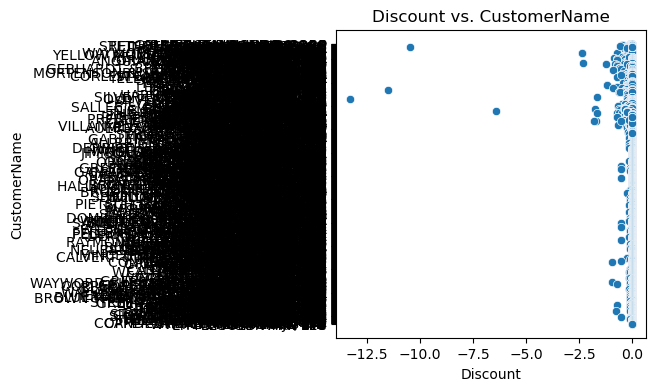

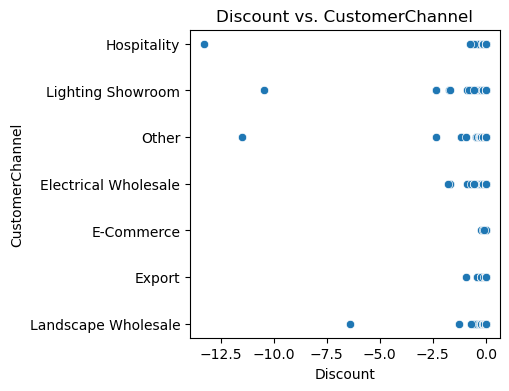

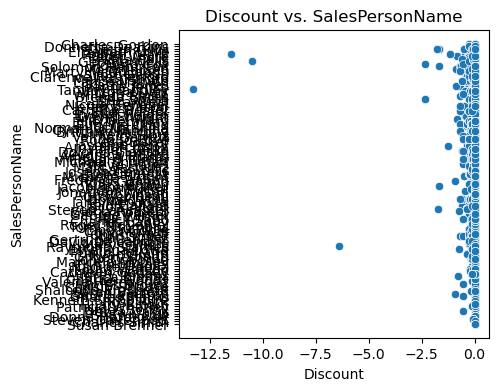

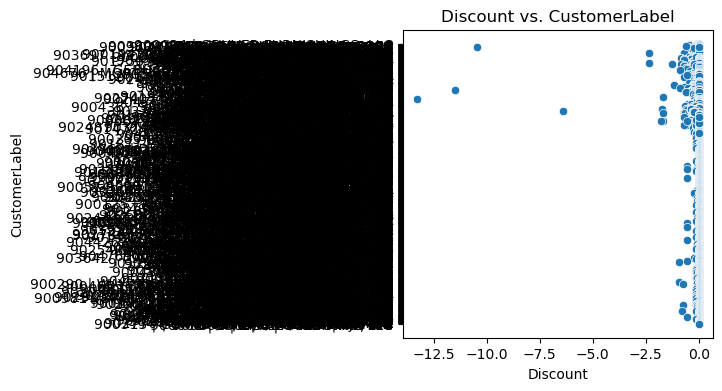

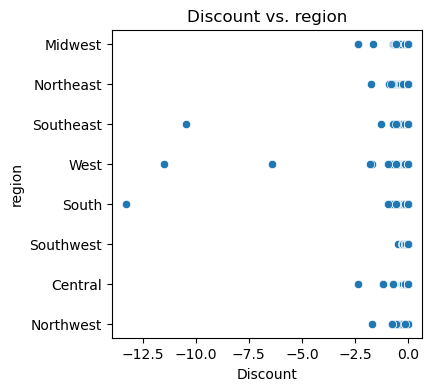

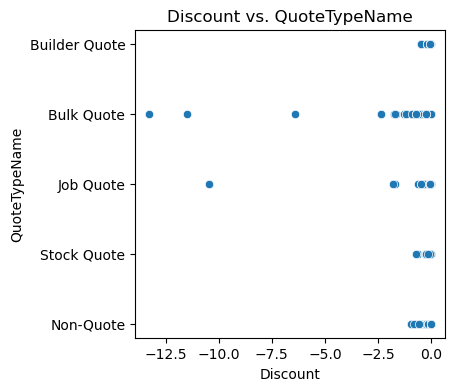

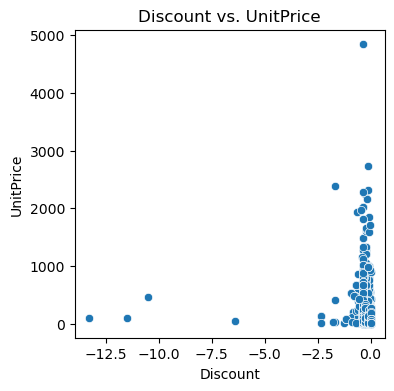

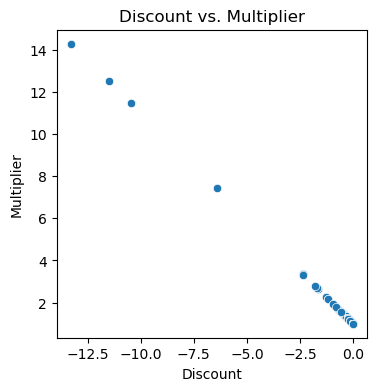

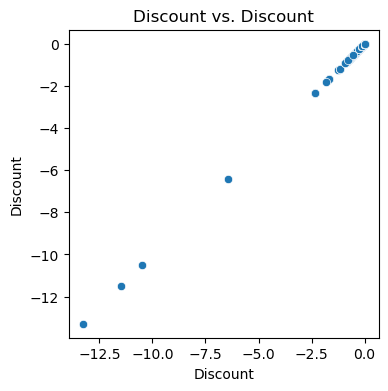

In [204]:
for colName in prod_neg:
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.scatterplot(data=prod_neg, x='Discount', y=colName)
    plt.title(f"Discount vs. {colName}")
    plt.show

We could look into different negative disocunt rates between efficient and not energy efficent products, different managers, and different regions.

But these 10,000 entries are not even 5% of our data, so we'll focus on the entries that have a discont rate of above 0.00%.

In [ ]:
df2 = df.loc[df['Discount'] > 0]
for colName in df2:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.scatterplot(x=df2['Discount'], y=df2[colName])
    plt.title(f"Discount vs. {colName}")
    plt.show

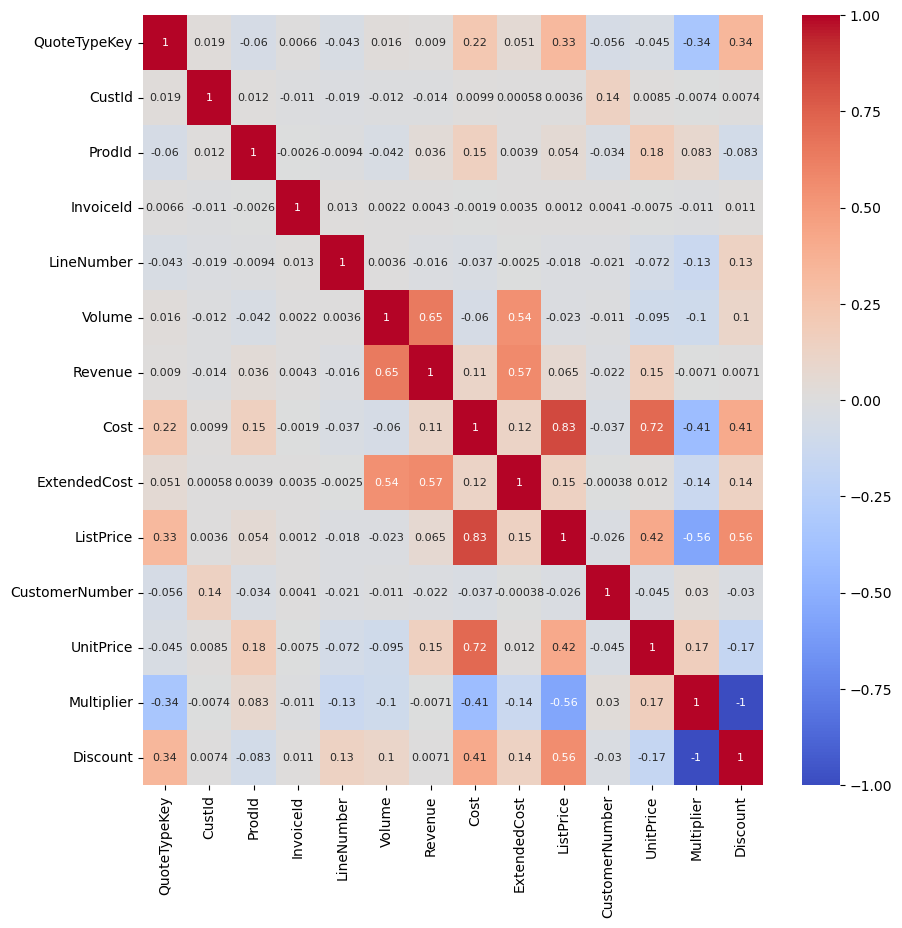

In [21]:
corr_matrix = df2.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'fontsize':8})
plt.show()

In [22]:
corr_with_discount = corr_matrix['Discount'].sort_values(ascending=False)
print(corr_with_discount)

Discount          1.000000
ListPrice         0.561558
Cost              0.407666
QuoteTypeKey      0.338860
ExtendedCost      0.135346
LineNumber        0.133508
Volume            0.103774
InvoiceId         0.011184
CustId            0.007354
Revenue           0.007074
CustomerNumber   -0.029960
ProdId           -0.082923
UnitPrice        -0.165319
Multiplier       -1.000000
Name: Discount, dtype: float64


In [23]:
from scipy.stats import pearsonr

corr, pval = pearsonr(df2['Discount'], df2['ListPrice'])

print("Correlation: ", corr)
print("P-value: ", pval)

Correlation:  0.5615580176054978
P-value:  0.0


In [24]:
corr, pval = pearsonr(df2['Discount'], df2['Cost'])

print("Correlation: ", corr)
print("P-value: ", pval)

Correlation:  0.4076660196728412
P-value:  0.0


Filtering the data to look at the invoice with only positive discount rates, we see a stronger correlation between Discount and ListPrice, as well as Discount and Cost. With a p-value below 0.05 on the Pearson test, we can say that this correlation is statistically significant, and not random.

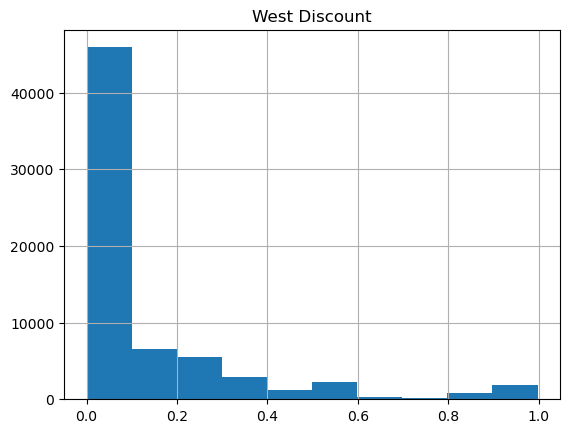

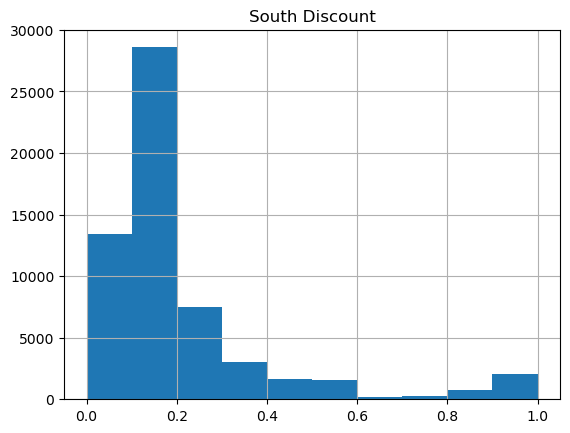

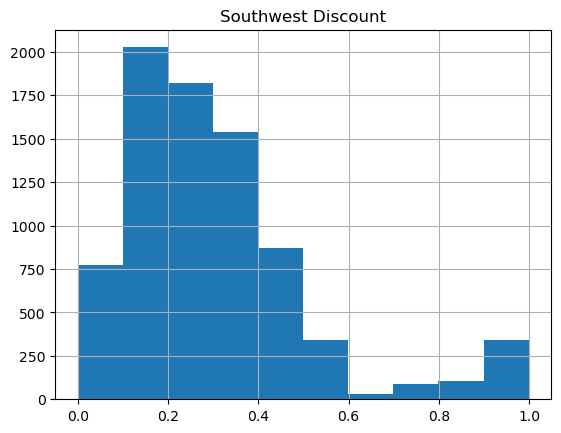

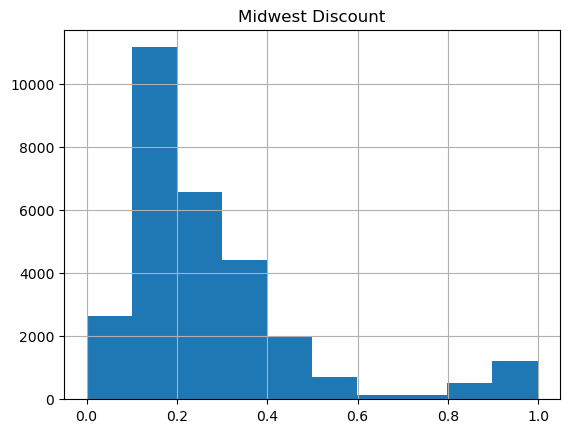

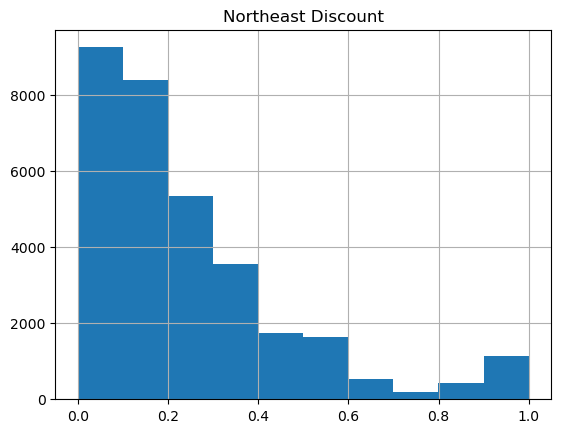

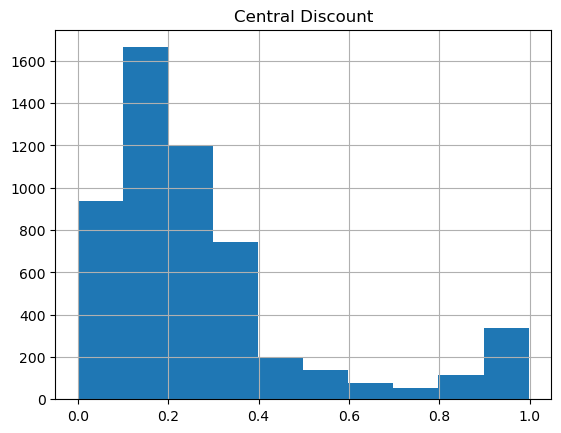

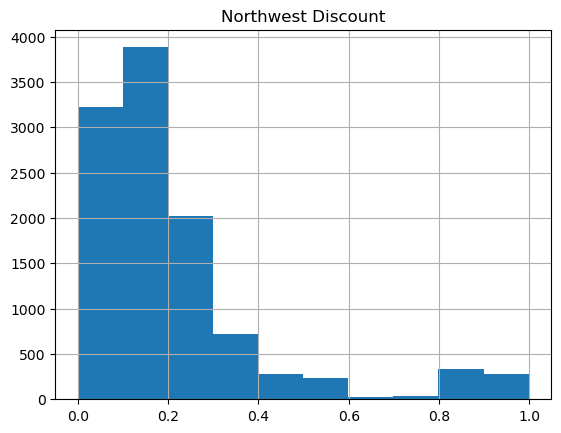

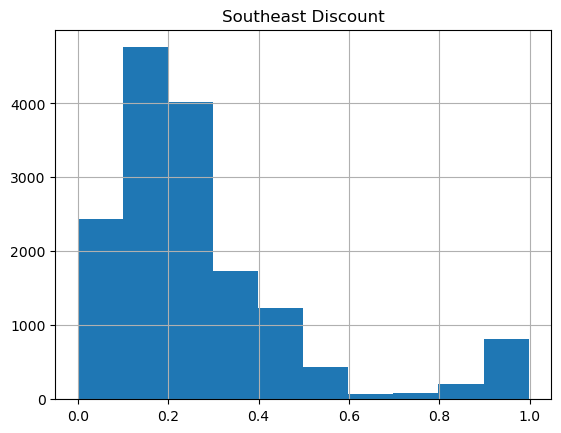

In [25]:
# I feel like there should be a correlation between different regions and their discount prices.

for region in df2['region'].unique():
    df2.loc[df2['region'] == region]['Discount'].hist()
    plt.title(f"{region} Discount")
    plt.show()

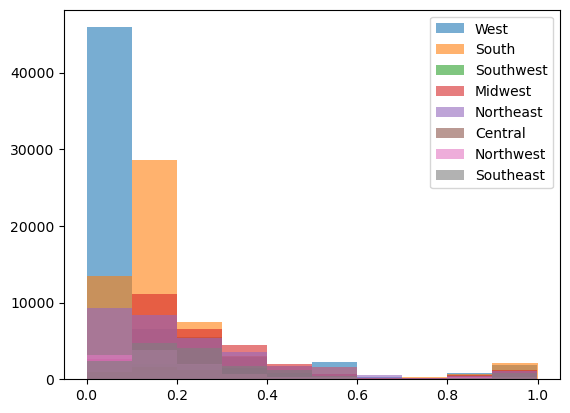

In [26]:
for region in df2['region'].unique():
    plt.hist(df2.loc[df2['region'] == region]['Discount'], alpha = 0.6)

plt.legend(df2['region'].unique(), loc='upper right')
plt.show()

In [27]:
# none of our data is normally distributed, with nonparametric data we're going to do a kruskal wallis test to 
# determine whether there is a statistically significant difference in the distribution of discount values 
# across different regions

# a big take away is that West is definetely getting more of the lowest discounts, South is getting 
# more and higher discounts on average than the rest

result = stats.kruskal(df.loc[df['region'] == 'Central', 'Discount'],
                       df.loc[df['region'] == 'Midwest', 'Discount'],
                       df.loc[df['region'] == 'Northeast', 'Discount'],
                       df.loc[df['region'] == 'Northwest', 'Discount'],
                       df.loc[df['region'] == 'South', 'Discount'],
                       df.loc[df['region'] == 'Southeast', 'Discount'],
                       df.loc[df['region'] == 'Southwest', 'Discount'],
                       df.loc[df['region'] == 'West', 'Discount'])

In [28]:
result

KruskalResult(statistic=10673.34324968016, pvalue=0.0)

Our pvalue is reallly low, and our high stat tells us that there are indeed signifiganct differences in discount values between different regions. So we can say the Kruskal–Wallis test is significant, then a post-hoc analysis can be performed to determine which groups differ from each other group. Probably the most popular post-hoc test for the Kruskal–Wallis test is the Dunn test.

So we know that discount rates are affected by their regions, list prices, and their cost.

In [29]:
data = pd.read_table("/Users/Yeti/Desktop/insight2profit/case-study-fans.txt")
df = pd.DataFrame(data)

3. Looking at the Fans category, we want to have a perspective on how List Prices are set relative to cost and perceived market value. Are there product attributes that could explain a higher markup or margin % from ListPrice?

In [30]:
df.head()

,ProductNumber,ProductDescription,Line,ProdId,Revenue,MarginPct,ListPrice,Cost,Volume,Products
0,12104,52 Inch Canfield Patio Fan,Builder Fans,7361,215268.96,0.773386,564.195875,127.854473,2712,1
1,12367,52 Inch Sutter Place Premier F,Builder Fans,1569,152664.59,0.740171,492.071488,127.854473,4538,1
2,12071,52 Inch Corinth Fan,Decorative Fans,14034,84828.33,0.815154,806.959473,149.163552,248,1
3,12099,54 Inch Seaside Fan,Decorative Fans,9667,73729.84,0.828952,905.597605,154.900612,9292,1
4,12366,52 Inch Sutter Place Premier F,Builder Fans,2031,57122.35,0.773386,564.195875,127.854473,397,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ProductNumber       146 non-null    object 
 1   ProductDescription  146 non-null    object 
 2   Line                135 non-null    object 
 3   ProdId              146 non-null    int64  
 4   Revenue             146 non-null    float64
 5   MarginPct           146 non-null    float64
 6   ListPrice           146 non-null    float64
 7   Cost                146 non-null    float64
 8   Volume              146 non-null    int64  
 9   Products            146 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 11.5+ KB


In [32]:
df.nunique()

ProductNumber         146
ProductDescription     85
Line                    2
ProdId                146
Revenue               140
MarginPct             129
ListPrice             128
Cost                   21
Volume                 87
Products                1
dtype: int64

In [33]:
df.describe()

,ProdId,Revenue,MarginPct,ListPrice,Cost,Volume,Products
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.0
mean,9470.171233,9362.840685,0.785385,657.952361,126.097429,273.993151,1.0
std,6027.971338,25087.209230,0.079865,276.140591,32.036586,1098.857811,0.0
min,142.000000,1.160000,0.329431,95.905634,40.978998,1.000000,1.0
25%,3573.000000,99.500000,0.773386,531.525354,123.756574,5.000000,1.0
50%,9395.500000,1329.745000,0.793912,633.951353,127.854473,27.500000,1.0
75%,14310.750000,8137.315000,0.817811,796.344405,149.163552,108.000000,1.0
max,20405.000000,215268.960000,0.926589,2062.547528,200.797089,9292.000000,1.0


In [34]:
# We're working with a much smaller dataset. 9 columns, 3 are objects, and 146 entries.
# Lets start by creating a markup column as well before we look for correlations

df['MarkUp'] = df['ListPrice']/df['Cost']

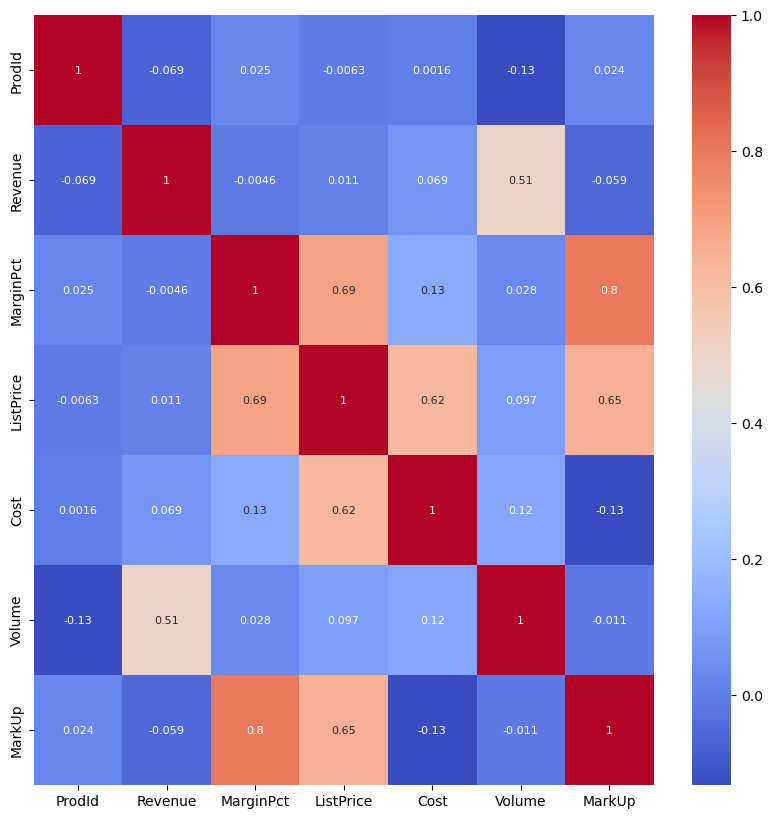

In [35]:
# drop products since there's nothing interesting it can tell us

df = df.drop(columns='Products')

corr_matrix = df.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={'fontsize':8})
plt.show()

In [36]:
corr_with_list = corr_matrix['ListPrice'].sort_values(ascending=False)
print(corr_with_list)

ListPrice    1.000000
MarginPct    0.689824
MarkUp       0.649023
Cost         0.616412
Volume       0.096843
Revenue      0.011228
ProdId      -0.006312
Name: ListPrice, dtype: float64


In [37]:
corr_with_margin = corr_matrix['MarginPct'].sort_values(ascending=False)
print(corr_with_margin)

MarginPct    1.000000
MarkUp       0.801781
ListPrice    0.689824
Cost         0.133378
Volume       0.028112
ProdId       0.024728
Revenue     -0.004647
Name: MarginPct, dtype: float64


In [38]:
corr_with_mark = corr_matrix['MarkUp'].sort_values(ascending=False)
print(corr_with_mark)

MarkUp       1.000000
MarginPct    0.801781
ListPrice    0.649023
ProdId       0.024437
Volume      -0.010603
Revenue     -0.058995
Cost        -0.131894
Name: MarkUp, dtype: float64


A common area to begin looking at when trying to understand List Prices would be the Cost of the good, higher costs usually mean higher list prices. Perhaps two different lines tend to have two different markup rates. Its not uncommon for items with high list prices to have lower volumes as well.

<AxesSubplot:xlabel='ListPrice', ylabel='Volume'>

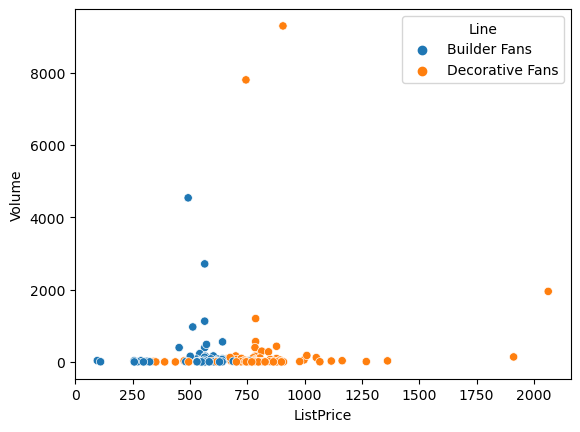

In [39]:
sns.scatterplot(data=df, x='ListPrice', y='Volume', hue='Line')

<AxesSubplot:xlabel='ListPrice', ylabel='Volume'>

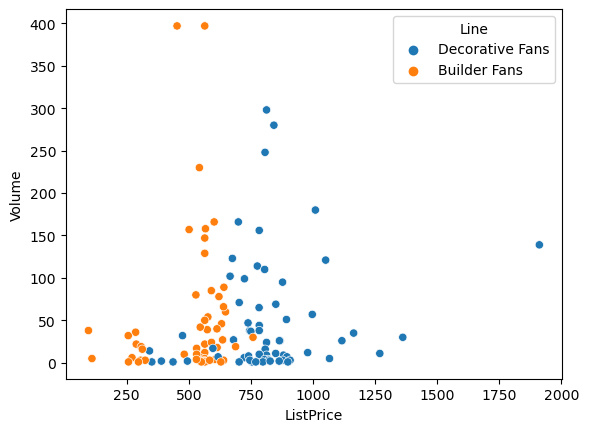

In [40]:
volume_threshold = df['Volume'].quantile(0.90)
df_filtered = df[df['Volume'] <= volume_threshold]
sns.scatterplot(data=df_filtered, x='ListPrice', y='Volume', hue='Line')

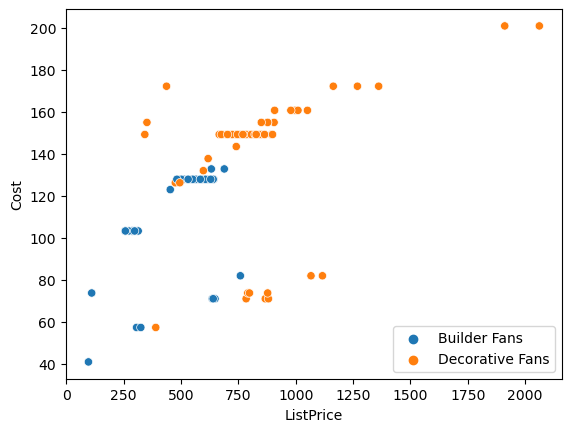

In [41]:
sns.scatterplot(data=df, x='ListPrice', y='Cost', hue='Line')
plt.legend(loc='lower right')
plt.show()

<AxesSubplot:xlabel='Cost', ylabel='Count'>

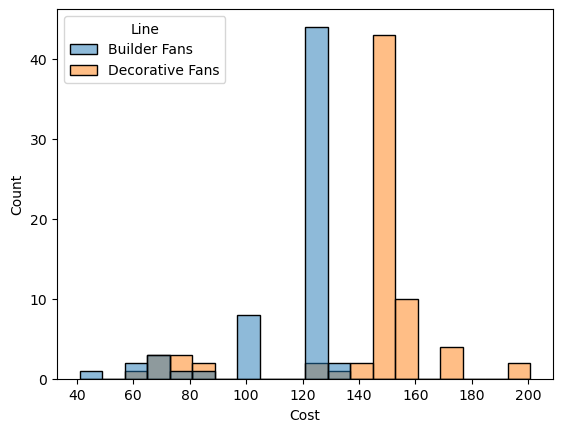

In [42]:
sns.histplot(x = df['Cost'], hue = df['Line'])

<AxesSubplot:xlabel='MarginPct', ylabel='Count'>

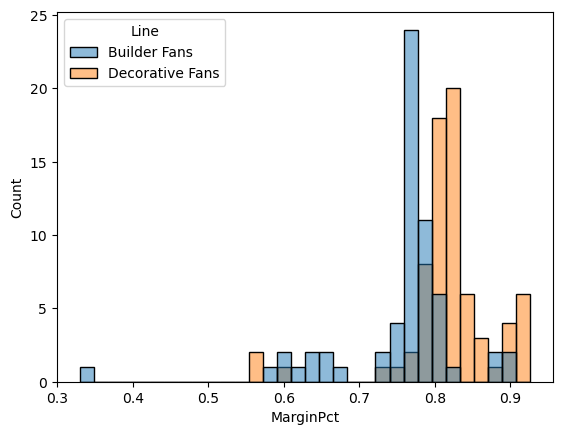

In [43]:
sns.histplot(x = df['MarginPct'], hue = df['Line'])

In [44]:
corr, pval = pearsonr(df['ListPrice'], df['Cost'])

print("Correlation: ", corr)
print("P-value: ", pval)

Correlation:  0.6164116599883195
P-value:  1.2063059901977578e-16


We've identified a correlation between Cost as well as ListPrice. Also, we see the Decorative Fans have higher Costs and higher ListPrices that Builder Fans. 

Two variables that can explain how List Price was set is the cost of the fan and its line.

In [45]:
data = pd.read_table("/Users/Yeti/Desktop/insight2profit/case-study-fans.txt")
df = pd.DataFrame(data)

4. Calculate an expected margin % or markup from List Price with additional product attributes to reduce the variation
Identify a product that is out of line with expectations
Determine what percent of items fall within 10% of expected prices


Output: Expected MarginPct

Input: Cost, ProductDescription, Line, Volume

Assumption: Product Manager isn't going to give us the List Price, so given the 4 input attributes, we need to calculate a MarginPct

How: One-hot encode Product Description and Line, remove outliers, and then run linear regression

In [46]:
df.head()

,ProductNumber,ProductDescription,Line,ProdId,Revenue,MarginPct,ListPrice,Cost,Volume,Products
0,12104,52 Inch Canfield Patio Fan,Builder Fans,7361,215268.96,0.773386,564.195875,127.854473,2712,1
1,12367,52 Inch Sutter Place Premier F,Builder Fans,1569,152664.59,0.740171,492.071488,127.854473,4538,1
2,12071,52 Inch Corinth Fan,Decorative Fans,14034,84828.33,0.815154,806.959473,149.163552,248,1
3,12099,54 Inch Seaside Fan,Decorative Fans,9667,73729.84,0.828952,905.597605,154.900612,9292,1
4,12366,52 Inch Sutter Place Premier F,Builder Fans,2031,57122.35,0.773386,564.195875,127.854473,397,1


In [47]:
df['ProductDescription'].nunique()

85

In [48]:
df['ProductDescription'].unique()

array(['52 Inch Canfield Patio Fan', '52 Inch Sutter Place Premier F',
       '52 Inch Corinth Fan', '54 Inch Seaside Fan',
       '52 Inch Stratmoor Fan', '52 Inch Structures Fan',
       '52 Inch Dorset Fan', '42 Inch Kichler Basics Premier',
       '52 Inch Walker fan', '52 Inch Dorset II Fan',
       '52 Inch Monarch II Patio Fan', '52 Inch Canfield Fan',
       '56 Inch High Country Fan', '70 inch Monarch Fan',
       '52 Inch Botella Fan', '52 Inch Heather Fan', '52 Inch Lacey Fan',
       '52 Inch Monarch II Fan', '52 Inch Saxon Fan',
       '70 Inch Monarch Fan', '52 Inch Leeds Fan',
       '52 Inch Kittery Point Fan', '56 Inch Hatteras Bay Fan',
       '52 Inch Sterling Manor Select', '46 Inch Eva Fan',
       '52 Inch Fitch Fan', '52 Inch Kemble Fan', '54 Inch Cadence Fan',
       '52 Inch Saxon Premier Fan', '52 Inch Aldrin Patio Fan',
       '52 Inch Acme Basics Select', '52 Inch Harbour Walk Patio Fan',
       'Sterling Manor-Non ES Subway', '52 Inch Deckard Fan',
       '

In [49]:
# Some fans use the same product description, and fortunately  
# there are repetitive words between the product descriptions

from mlxtend.preprocessing import TransactionEncoder

prod_des = df.loc[df['ProductDescription'].notnull(), 'ProductDescription'].astype('str').apply(lambda t: t.split(' '))
prod_des = list(prod_des)

encoder = TransactionEncoder().fit(prod_des)
onehot_prod = encoder.transform(prod_des)

onehot_prod = pd.DataFrame(onehot_prod, columns = encoder.columns_, index=df.loc[df.ProductDescription.notnull(), 'ProdId'])

In [50]:
onehot_prod = onehot_prod * 1
onehot_prod.head()

,30,42,44,46,48,5,52,54,56,60,70,Acme,Aldrin,Arius,Arkwright,BLADE,BLD7,Basics,Bay,Bellamy,Bentzen,Body,Botella,Brinbourne,Bronson,Cadence,Cameron,Canfield,Carlson,Celino,Ceres,Chicago,Circolo,Climates,Corinth,Cortez,Country,Crystal,Deckard,Dorset,ES,Eva,F,Fa,Fan,Ferron,Fitch,Harbour,Hatteras,Heather,Hendrick,High,Highland,II,INCH,Inch,Kedron,Kemble,Keswick,Kichler,Kittery,Lacey,Leeds,Lucia,MANOR,Makoda,Manor,Manor-Non,Merrick,Monarch,Olympia,Patio,Place,Point,Premier,Pro,Ridley,Rivetta,Rochelle,STERLING,Saxon,Seaside,Select,Sterling,Stratmoor,Structures,Subway,Sutter,Talbot,Tolkin,Trevor,Valkyrie,Vance,Walk,Walker,Whitmore,Wilton,fan,inch
ProdId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7361,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1569,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
14034,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9667,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2031,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [51]:
line_des = df.loc[df['Line'].notnull(), 'Line'].astype('str').apply(lambda t: t.split(', '))
line_des = list(line_des)

encoder = TransactionEncoder().fit(line_des)
onehot_line = encoder.transform(line_des)

onehot_line = pd.DataFrame(onehot_line, columns = encoder.columns_, index=df.loc[df.Line.notnull(), 'ProdId'])

In [52]:
onehot_line = onehot_line * 1
onehot_line.head()

,Builder Fans,Decorative Fans
ProdId,,
7361,1,0
1569,1,0
14034,0,1
9667,0,1
2031,1,0


In [53]:
onehot_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 7361 to 13941
Data columns (total 99 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   30          146 non-null    int64
 1   42          146 non-null    int64
 2   44          146 non-null    int64
 3   46          146 non-null    int64
 4   48          146 non-null    int64
 5   5           146 non-null    int64
 6   52          146 non-null    int64
 7   54          146 non-null    int64
 8   56          146 non-null    int64
 9   60          146 non-null    int64
 10  70          146 non-null    int64
 11  Acme        146 non-null    int64
 12  Aldrin      146 non-null    int64
 13  Arius       146 non-null    int64
 14  Arkwright   146 non-null    int64
 15  BLADE       146 non-null    int64
 16  BLD7        146 non-null    int64
 17  Basics      146 non-null    int64
 18  Bay         146 non-null    int64
 19  Bellamy     146 non-null    int64
 20  Bentzen     146 non-null   

In [54]:
# our product desciption table is 98 words, which isn't bad, it tells us that a lot of the
# descriptive words were reused between the 146 entries

train_df = pd.merge(onehot_prod, onehot_line, on='ProdId')

In [55]:
full_df = train_df.merge(df[['Cost', 'Volume', 'ProdId', 'MarginPct']], on='ProdId')

In [56]:
full_df.head()

,ProdId,30,42,44,46,48,5,52,54,56,60,70,Acme,Aldrin,Arius,Arkwright,BLADE,BLD7,Basics,Bay,Bellamy,Bentzen,Body,Botella,Brinbourne,Bronson,Cadence,Cameron,Canfield,Carlson,Celino,Ceres,Chicago,Circolo,Climates,Corinth,Cortez,Country,Crystal,Deckard,Dorset,ES,Eva,F,Fa,Fan,Ferron,Fitch,Harbour,Hatteras,Heather,Hendrick,High,Highland,II,INCH,Inch,Kedron,Kemble,Keswick,Kichler,Kittery,Lacey,Leeds,Lucia,MANOR,Makoda,Manor,Manor-Non,Merrick,Monarch,Olympia,Patio,Place,Point,Premier,Pro,Ridley,Rivetta,Rochelle,STERLING,Saxon,Seaside,Select,Sterling,Stratmoor,Structures,Subway,Sutter,Talbot,Tolkin,Trevor,Valkyrie,Vance,Walk,Walker,Whitmore,Wilton,fan,inch,Builder Fans,Decorative Fans,Cost,Volume,MarginPct
0,7361,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,127.854473,2712,0.773386
1,1569,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,127.854473,4538,0.740171
2,14034,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,149.163552,248,0.815154
3,9667,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,154.900612,9292,0.828952
4,2031,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,127.854473,397,0.773386


In [57]:
full_df = full_df.iloc[:, ::-1]
full_df.head()


,MarginPct,Volume,Cost,Decorative Fans,Builder Fans,inch,fan,Wilton,Whitmore,Walker,Walk,Vance,Valkyrie,Trevor,Tolkin,Talbot,Sutter,Subway,Structures,Stratmoor,Sterling,Select,Seaside,Saxon,STERLING,Rochelle,Rivetta,Ridley,Pro,Premier,Point,Place,Patio,Olympia,Monarch,Merrick,Manor-Non,Manor,Makoda,MANOR,Lucia,Leeds,Lacey,Kittery,Kichler,Keswick,Kemble,Kedron,Inch,INCH,II,Highland,High,Hendrick,Heather,Hatteras,Harbour,Fitch,Ferron,Fan,Fa,F,Eva,ES,Dorset,Deckard,Crystal,Country,Cortez,Corinth,Climates,Circolo,Chicago,Ceres,Celino,Carlson,Canfield,Cameron,Cadence,Bronson,Brinbourne,Botella,Body,Bentzen,Bellamy,Bay,Basics,BLD7,BLADE,Arkwright,Arius,Aldrin,Acme,70,60,56,54,52,5,48,46,44,42,30,ProdId
0,0.773386,2712,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7361
1,0.740171,4538,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1569
2,0.815154,248,149.163552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14034
3,0.828952,9292,154.900612,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9667
4,0.773386,397,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2031


In [58]:
X = full_df.drop(columns=['ProdId', 'MarginPct'])
Y = full_df['MarginPct']

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [137]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [138]:
y_pred = model.predict(x_test)

In [139]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

print('R-squared:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R-squared: 0.5947117209197701
MSE: 0.005261795450201599
MAE: 0.04198608210485493


In [140]:
y_pred = model.predict(X)

In [141]:
full_df['ExpectedMarginPct'] = y_pred
full_df.head(10)

,MarginPct,Volume,Cost,Decorative Fans,Builder Fans,inch,fan,Wilton,Whitmore,Walker,Walk,Vance,Valkyrie,Trevor,Tolkin,Talbot,Sutter,Subway,Structures,Stratmoor,Sterling,Select,Seaside,Saxon,STERLING,Rochelle,Rivetta,Ridley,Pro,Premier,Point,Place,Patio,Olympia,Monarch,Merrick,Manor-Non,Manor,Makoda,MANOR,Lucia,Leeds,Lacey,Kittery,Kichler,Keswick,Kemble,Kedron,Inch,INCH,II,Highland,High,Hendrick,Heather,Hatteras,Harbour,Fitch,Ferron,Fan,Fa,F,Eva,ES,Dorset,Deckard,Crystal,Country,Cortez,Corinth,Climates,Circolo,Chicago,Ceres,Celino,Carlson,Canfield,Cameron,Cadence,Bronson,Brinbourne,Botella,Body,Bentzen,Bellamy,Bay,Basics,BLD7,BLADE,Arkwright,Arius,Aldrin,Acme,70,60,56,54,52,5,48,46,44,42,30,ProdId,ExpectedMarginPct,ProductDescription,Accuracy,Within10,Within5
0,0.773386,2712,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7361,0.778260,52 Inch Canfield Patio Fan,99.439671,1,1
1,0.740171,4538,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1569,0.758535,52 Inch Sutter Place Premier F,97.384970,1,1
2,0.815154,248,149.163552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14034,0.813594,52 Inch Corinth Fan,100.000000,1,1
3,0.828952,9292,154.900612,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9667,0.819568,54 Inch Seaside Fan,80.685449,0,0
4,0.773386,397,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2031,0.764752,52 Inch Sutter Place Premier F,99.364349,1,1
5,0.773386,1128,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1032,0.768753,52 Inch Stratmoor Fan,98.547543,1,1
6,0.786746,166,149.163552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17535,0.786746,52 Inch Structures Fan,100.000000,1,1
7,0.810315,564,149.163552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4749,0.742914,52 Inch Dorset Fan,100.000000,1,1
8,0.809645,398,149.163552,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17353,0.809645,52 Inch Walker fan,100.000000,1,1
9,0.776101,102,149.163552,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,13214,0.776101,52 Inch Dorset II Fan,94.864510,1,0


In [142]:
full_df = full_df.merge(df[['ProductDescription', 'ProdId']], on='ProdId')

<AxesSubplot:xlabel='MarginPct', ylabel='ExpectedMarginPct'>

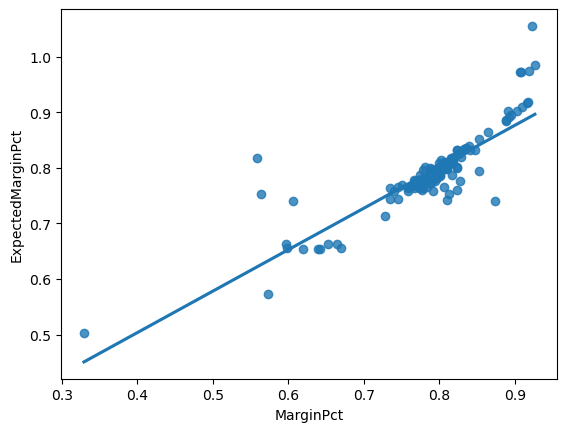

In [152]:
sns.regplot(data=full_df, x='MarginPct', y='ExpectedMarginPct', ci=None)

In [66]:
full_df['Accuracy'] = (1 - (full_df['ExpectedMarginPct'] - full_df['MarginPct']).abs()/full_df['MarginPct']) * 100

In [67]:
# to see products that fall out of line of expectations

full_df.sort_values('Accuracy')

,MarginPct,Volume,Cost,Decorative Fans,Builder Fans,inch,fan,Wilton,Whitmore,Walker,Walk,Vance,Valkyrie,Trevor,Tolkin,Talbot,Sutter,Subway,Structures,Stratmoor,Sterling,Select,Seaside,Saxon,STERLING,Rochelle,Rivetta,Ridley,Pro,Premier,Point,Place,Patio,Olympia,Monarch,Merrick,Manor-Non,Manor,Makoda,MANOR,Lucia,Leeds,Lacey,Kittery,Kichler,Keswick,Kemble,Kedron,Inch,INCH,II,Highland,High,Hendrick,Heather,Hatteras,Harbour,Fitch,Ferron,Fan,Fa,F,Eva,ES,Dorset,Deckard,Crystal,Country,Cortez,Corinth,Climates,Circolo,Chicago,Ceres,Celino,Carlson,Canfield,Cameron,Cadence,Bronson,Brinbourne,Botella,Body,Bentzen,Bellamy,Bay,Basics,BLD7,BLADE,Arkwright,Arius,Aldrin,Acme,70,60,56,54,52,5,48,46,44,42,30,ProdId,ExpectedMarginPct,ProductDescription,Accuracy
104,0.817741,11,154.900612,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1787,0.558688,54 Inch Bellamy Fan,68.320917
102,0.329431,5,73.762196,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4241,0.405254,30 Inch Canfield Fan,76.983809
132,0.605627,1,172.111791,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16163,0.739643,60 Inch Olympia Fan,77.871477
92,0.807132,19,132.771953,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,7576,0.631276,54 Inch Kedron Fan,78.212302
39,0.789862,46,132.771953,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,19357,0.631218,54 Inch Kedron Fan,79.914981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.906721,6,73.762196,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9798,0.906721,54 Inch Vance Fan,100.000000
48,0.791560,40,127.854473,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,14175,0.791560,52 Inch Canfield Pro Fan,100.000000
100,0.835867,12,160.637672,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1647,0.835867,56 Inch Highland Manor Fan,100.000000
101,0.852712,2,57.370597,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3985,0.852712,42 Inch Rivetta II Fan,100.000000


The 54 Inch Bellamy Fan, Product ID 1787, is a product that is out of line with expectations, the Expected Margin is 55.8% while the actual is 81.7%.

In [153]:
# we're assuming we want to check if the margin is within 10% above or below our expected margins

full_df['Within10'] = (full_df['MarginPct'] - full_df['ExpectedMarginPct']).abs()/full_df['ExpectedMarginPct'] <= 0.10
full_df['Within10'] = full_df['Within10'] * 1

In [154]:
# to get the ProdIds for those within 10%

df['Within10'] = full_df['Within10']
df['Accuracy'] = full_df['Accuracy']
filtered_df = df.loc[df['Within10'] == 1]
filtered_df.head()

,ProductNumber,ProductDescription,Line,ProdId,Revenue,MarginPct,ListPrice,Cost,Volume,Products,Within10,Accuracy,Within5
0,12104,52 Inch Canfield Patio Fan,Builder Fans,7361,215268.96,0.773386,564.195875,127.854473,2712,1,1.0,99.439671,1.0
1,12367,52 Inch Sutter Place Premier F,Builder Fans,1569,152664.59,0.740171,492.071488,127.854473,4538,1,1.0,97.384970,1.0
2,12071,52 Inch Corinth Fan,Decorative Fans,14034,84828.33,0.815154,806.959473,149.163552,248,1,1.0,100.000000,1.0
3,12099,54 Inch Seaside Fan,Decorative Fans,9667,73729.84,0.828952,905.597605,154.900612,9292,1,1.0,80.685449,0.0
4,12366,52 Inch Sutter Place Premier F,Builder Fans,2031,57122.35,0.773386,564.195875,127.854473,397,1,1.0,99.364349,1.0


In [155]:
filtered_df[['ProdId', 'ProductDescription', 'Accuracy']].round({'Accuracy': 2})

,ProdId,ProductDescription,Accuracy
0,7361,52 Inch Canfield Patio Fan,99.44
1,1569,52 Inch Sutter Place Premier F,97.38
2,14034,52 Inch Corinth Fan,100.00
3,9667,54 Inch Seaside Fan,80.69
4,2031,52 Inch Sutter Place Premier F,99.36
...,...,...,...
129,16418,52 Inch Kittery Point Fan,92.93
130,1883,52 Inch Carlson Fan,94.10
131,2082,52 Inch Sutter Place Fan,99.56
133,10337,52 Inch Monarch II Select Fan,95.71


These 129 out of 146 products, or 88%, fall within 10% of the expected margins.

In [156]:
full_df['Within5'] = (full_df['MarginPct'] - full_df['ExpectedMarginPct']).abs()/full_df['ExpectedMarginPct'] <= 0.05
full_df['Within5'] = full_df['Within5'] * 1
df['Within5'] = full_df['Within5']
filtered_df2 = df.loc[df['Within5'] == 1]
filtered_df2.head()

,ProductNumber,ProductDescription,Line,ProdId,Revenue,MarginPct,ListPrice,Cost,Volume,Products,Within10,Accuracy,Within5
0,12104,52 Inch Canfield Patio Fan,Builder Fans,7361,215268.96,0.773386,564.195875,127.854473,2712,1,1.0,99.439671,1.0
1,12367,52 Inch Sutter Place Premier F,Builder Fans,1569,152664.59,0.740171,492.071488,127.854473,4538,1,1.0,97.384970,1.0
2,12071,52 Inch Corinth Fan,Decorative Fans,14034,84828.33,0.815154,806.959473,149.163552,248,1,1.0,100.000000,1.0
3,12099,54 Inch Seaside Fan,Decorative Fans,9667,73729.84,0.828952,905.597605,154.900612,9292,1,1.0,80.685449,1.0
4,12366,52 Inch Sutter Place Premier F,Builder Fans,2031,57122.35,0.773386,564.195875,127.854473,397,1,1.0,99.364349,1.0


In [157]:
filtered_df2[['ProdId', 'ProductDescription', 'Accuracy']].round({'Accuracy': 2})

,ProdId,ProductDescription,Accuracy
0,7361,52 Inch Canfield Patio Fan,99.44
1,1569,52 Inch Sutter Place Premier F,97.38
2,14034,52 Inch Corinth Fan,100.00
3,9667,54 Inch Seaside Fan,80.69
4,2031,52 Inch Sutter Place Premier F,99.36
...,...,...,...
127,5341,52 Inch Walker fan,98.02
129,16418,52 Inch Kittery Point Fan,92.93
131,2082,52 Inch Sutter Place Fan,99.56
133,10337,52 Inch Monarch II Select Fan,95.71


And these 116, or 79%, lie with 5% above or 5% below our Expected Margins.

Given more time, 

For question 1, I would explore the data more indepth, especially the columns that have around 10 or less unique values. I found that there were different zones responsisible for product 528 having different list prices, but im sure there are other variables that can be found.

For question 2, I would do more tests afterwards to see which region receives the most discounts, the highest discounts, the least discounts, the lowest discounts, and if specific salespersons or managers are tied to these stats.

For questions 3, I would definetly look more into the relationship between ListPrice and Cost, and see if there are any other varables that may have an influence, whether its Volume or ProductManager.

For question 4, I would like to clean up and explore the data more. I could remove outliers from Volume, or perhaps I Could remove the least frequent words in the product descriptions.
